In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub

In [ ]:
data = [["not sure", "maybe"],
        ["I may agree", "maybe"],
        ["I don't know", "no"],
        ["I have no clue", "no"],
        ["I think so", "yes"],
        ["I agree", "yes"],
        ["I'm not sure if I agree", "maybe"],
        ["I may agree", "maybe"],
        ["I might agree", "maybe"],
        ["I'm not sure", "maybe"],
        ["I don't have a clue", "no"],
        ["I don't have a clue", "no"],
        ["I have no clue", "no"],
        ["I have no idea", "no"],
        ["No idea", "no"],
        ["dunno", "no"],
        ["I've changed my mind", "no"],
        ["I don't agree", "no"],
        ["I do not agree", "no"],
        ["Absolutely not", "no"],
        ["belay that", "no"],
        ["cut it out", "no"],
        ["don't do anything", "no"],
        ["don't do it", "no"],
        ["forget it", "no"],
        ["forget about it", "no"],
        ["never mind", "no"],
        ["no thanks", "no"],
        ["no thank you", "no"],
        ["no way", "no"],
        ["on second thought, don't do it", "no"],
        ["please don't", "no"],
        ["scratch that", "no"],
        ["cancel", "no"],
        ["denied", "no"],
        ["disconnect", "no"],
        ["disengage", "no"],
        ["don't", "no"],
        ["end", "no"],
        ["exit", "no"],
        ["halt", "no"],
        ["n", "no"],
        ["q", "no"],
        ["nah", "no"],
        ["nay", "no"],
        ["neg", "no"],
        ["negative", "no"],
        ["negatory", "no"],
        ["nein", "no"],
        ["nevermind", "no"],
        ["no", "no"],
        ["no", "no"],
        ["nope", "no"],
        ["nope", "no"],
        ["nyet", "no"],
        ["skip", "no"],
        ["stop", "no"],
        ["stop", "no"],
        ["quit", "no"],
        ["I agree", "yes"],
        ["I agree", "yes"],
        ["I'm sure", "yes"],
        ["I'm sure", "yes"],
        ["aye aye", "yes"],
        ["aye", "yes"],
        ["carry on", "yes"],
        ["do it", "yes"],
        ["do it", "yes"],
        ["get on with it then", "yes"],
        ["go ahead", "yes"],
        ["i agree", "yes"],
        ["make it happen", "yes"],
        ["make it so", "yes"],
        ["most assuredly", "yes"],
        ["perfect, thanks", "yes"],
        ["please do", "yes"],
        ["rock on", "yes"],
        ["that's correct", "yes"],
        ["that's right", "yes"],
        ["uh huh", "yes"],
        ["yeah, do it", "yes"],
        ["yes, do it", "yes"],
        ["yes, please", "yes"],
        ["you got it", "yes"],
        ["absolutely", "yes"],
        ["yes, absolutely", "yes"],
        ["affirmative", "yes"],
        ["alright", "yes"],
        ["aye", "yes"],
        ["certainly", "yes"],
        ["confirmed", "yes"],
        ["continue", "yes"],
        ["correct", "yes"],
        ["da", "yes"],
        ["good", "yes"],
        ["hooray", "yes"],
        ["ja", "yes"],
        ["ok", "yes"],
        ["ok", "yes"],
        ["okay", "yes"],
        ["proceed", "yes"],
        ["righto", "yes"],
        ["sure", "yes"],
        ["sure", "yes"],
        ["sure", "yes"],
        ["sure", "yes"],
        ["thanks", "yes"],
        ["totally", "yes"],
        ["true", "yes"],
        ["y", "yes"],
        ["ya", "yes"],
        ["ya", "yes"],
        ["yay", "yes"],
        ["yea", "yes"],
        ["yeah", "yes"],
        ["yeah", "yes"],
        ["yep", "yes"],
        ["yeppers", "yes"],
        ["yes", "yes"],
        ["yes", "yes"],
        ["yes", "yes"],
        ["k!", "yes"]
]

In [ ]:
df = pd.DataFrame(data,columns=['responses','sentiment'])
print(df.shape)
df

(122, 2)


,responses,sentiment
0,not sure,maybe
1,I may agree,maybe
2,I don't know,no
3,I have no clue,no
4,I think so,yes
...,...,...
117,yeppers,yes
118,yes,yes
119,yes,yes
120,yes,yes


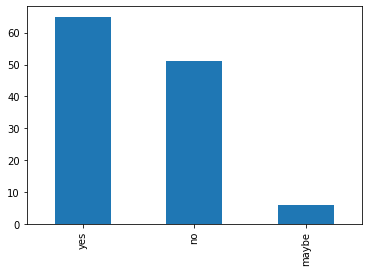

In [ ]:
df['sentiment'].value_counts().plot.bar()

In [ ]:
# Load Pretrained Word2Vec
#embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")
embed = hub.load("https://tfhub.dev/google/Wiki-words-500/2")

In [ ]:
def get_max_length(df):
    """
    get max token counts from train data, 
    so we use this number as fixed length input to RNN cell
    """
    max_length = 0
    for row in df['responses']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length

def get_word2vec_enc(responses):
    """
    get word2vec value for each word in sentence.
    concatenate word in numpy array, so we can use it as RNN input
    """
    encoded_reviews = []
    for response in responses:
        tokens = response.split(" ")
        word2vec_embedding = embed(tokens)
        encoded_reviews.append(word2vec_embedding)
    return encoded_reviews
        
def get_padded_encoded_reviews(encoded_reviews):
    """
    for short sentences, we prepend zero padding so all input to RNN has same length
    """
    padded_reviews_encoding = []
    for enc_review in encoded_reviews:
        zero_padding_cnt = max_length - enc_review.shape[0]
        pad = np.zeros((1, 500))
        for i in range(zero_padding_cnt):
            enc_review = np.concatenate((pad, enc_review), axis=0)
        padded_reviews_encoding.append(enc_review)
    return padded_reviews_encoding

def sentiment_encode(sentiment):
    """
    return one hot encoding for Y value
    """
    if sentiment == 'yes':
        return [1,0,0]
    elif sentiment == 'no':
        return [0,1,0]
    else:
        return [0,0,1]
    
def preprocess(df):
    """
    encode text value to numeric value
    """
    # encode words into word2vec
    reviews = df['responses'].tolist()
    
    encoded_reviews = get_word2vec_enc(reviews)
    padded_encoded_reviews = get_padded_encoded_reviews(encoded_reviews)
    # encoded sentiment
    sentiments = df['sentiment'].tolist()
    encoded_sentiment = [sentiment_encode(sentiment) for sentiment in sentiments]
    X = np.array(padded_encoded_reviews)
    y = np.array(encoded_sentiment)
    return X, y

In [ ]:
# max_length is used for max sequence of input
max_length = get_max_length(df)

train_X, train_Y = preprocess(df)

In [ ]:
# LSTM model
model = Sequential()
model.add(LSTM(32))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
print('Train...')
model.fit(train_X, train_Y,epochs=50)

Train...
Epoch 1/50
4/4 [==============================] - 2s 9ms/step - loss: 1.0813 - accuracy: 0.3934
Epoch 2/50
4/4 [==============================] - 0s 8ms/step - loss: 1.0484 - accuracy: 0.5574
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 1.0155 - accuracy: 0.6148
Epoch 4/50
4/4 [==============================] - 0s 8ms/step - loss: 0.9899 - accuracy: 0.6148
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 0.9642 - accuracy: 0.6311
Epoch 6/50
4/4 [==============================] - 0s 7ms/step - loss: 0.9432 - accuracy: 0.6475
Epoch 7/50
4/4 [==============================] - 0s 9ms/step - loss: 0.9209 - accuracy: 0.6721
Epoch 8/50
4/4 [==============================] - 0s 9ms/step - loss: 0.9025 - accuracy: 0.6639
Epoch 9/50
4/4 [==============================] - 0s 7ms/step - loss: 0.8855 - accuracy: 0.6639
Epoch 10/50
4/4 [==============================] - 0s 7ms/step - loss: 0.8675 - accuracy: 0.6639
Epoch 11/50
4/4 [=============

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                68224     
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 68,323
Trainable params: 68,323
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test = [
         {'responses': 'Yess!!', 'sentiment': 'yes'},
         {'responses': 'Sure thing!', 'sentiment': 'yes'},
         {'responses': 'Naah', 'sentiment': 'no'},
         {'responses': 'Nay', 'sentiment': 'No'},
         {'responses': 'ummmm let me think about it', 'sentiment': 'maybe'},
         {'responses': 'I could but..', 'sentiment': 'maybe'}
    ]
test_df = pd.DataFrame(test)

test_X, test_Y = preprocess(test_df)

score, acc = model.evaluate(test_X, test_Y, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

1/1 - 1s - loss: 2.0723 - accuracy: 0.3333
Test score: 2.072333574295044
Test accuracy: 0.3333333432674408
